# Predictive Analytics and Forecasting


## Learning Objectives
- Learn time series analysis and forecasting methods.  
- Understand moving average, exponential smoothing, ARIMA, and state space models.  
- Practice financial analytics and fraud detection on simulated data.  
- Engineer features for time series data.  
- Apply forecasting in practical business situations.  
- Build a small end-to-end simulation to compare models and measure accuracy.

In [ ]:
# === Setup (safe to run in Colab) ===
# You may comment out packages you already have.
!pip -q install statsmodels pmdarima scikit-learn yfinance pandas numpy matplotlib --upgrade

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 109.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.0 which is incompatible.
op

## Introduction
We will simulate realistic time series that include trend, seasonality, and shocks. We will then fit baseline statistical models and machine learning pipelines and compare performance.

## Time Series Fundamentals
A univariate time series can be decomposed into level, trend, seasonality, and irregular noise. Many classical models assume additive or multiplicative structure. We will create data with controlled components to verify that models recover the signal.

In [ ]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(7)

n = 730  # two years of daily data
t = np.arange(n)

# Components
level = 50
trend = 0.05 * t
seasonal = 10 * np.sin(2 * np.pi * t / 7)  # weekly
promo = (rng.random(n) < 0.05).astype(float)  # random promotions
promo_lift = 8 * promo
shock = np.zeros(n)
shock[200] = 25  # one-time spike
noise = rng.normal(0, 3, n)

y = level + trend + seasonal + promo_lift + shock + noise

df = pd.DataFrame({
    "ds": pd.date_range("2023-01-01", periods=n, freq="D"),
    "y": y,
    "promo": promo
})
df.head()

,ds,y,promo
0,2023-01-01,48.976125,0.0
1,2023-01-02,52.796869,0.0
2,2023-01-03,60.952903,0.0
3,2023-01-04,52.264686,0.0
4,2023-01-05,44.870580,0.0


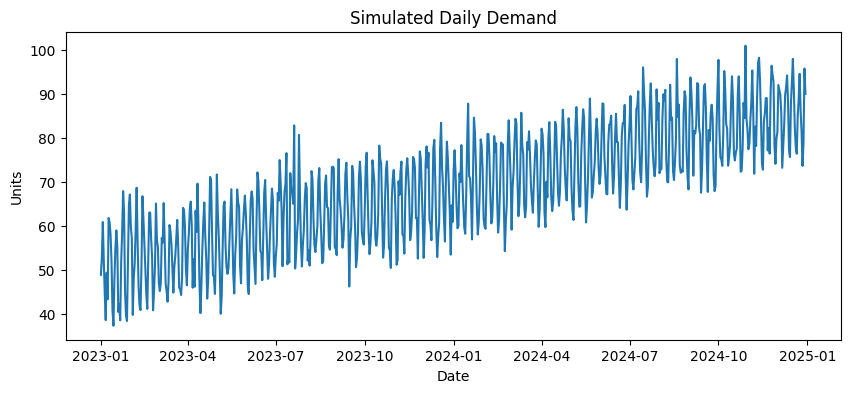

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df["ds"], df["y"])
plt.title("Simulated Daily Demand")
plt.xlabel("Date"); plt.ylabel("Units")
plt.show()

In [ ]:
# Hold out the last 90 days for testing
train = df.iloc[:-90].copy()
test = df.iloc[-90:].copy()
len(train), len(test)

(640, 90)

## Moving Average and Simple Exponential Smoothing
We start with a naive baseline and a simple smoother.

In [ ]:
# Uninstall the current version of numpy
!pip uninstall -y numpy

# Install a potentially compatible version
!pip install numpy==1.25.2

Found existing installation: numpy 2.4.0
Uninstalling numpy-2.4.0:
  Successfully uninstalled numpy-2.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 92.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import numpy as np
import pandas as pd

# Rolling mean baseline (window=7)
ma_last = train["y"].rolling(7).mean().iloc[-1]
ma_forecast = np.repeat(ma_last, len(test))

# Simple Exponential Smoothing implemented directly
def ses_fit_predict(y_train, horizon, alphas=np.linspace(0.05, 0.95, 19)):
    yv = np.asarray(y_train, dtype=float)
    def ses_in_sample(alpha):
        level = yv[0]
        fitted = np.empty_like(yv)
        fitted[0] = level
        for t in range(1, len(yv)):
            level = alpha * yv[t-1] + (1 - alpha) * level
            fitted[t] = level
        return fitted

    # choose alpha by minimizing RMSE on one-step ahead residuals
    best_alpha, best_rmse = None, float("inf")
    for a in alphas:
        fitted = ses_in_sample(a)
        resid = yv - fitted
        rmse = np.sqrt(np.mean(resid[1:]**2))
        if rmse < best_rmse:
            best_rmse, best_alpha = rmse, a

    # refit with best alpha and produce horizon-step forecasts (constant level)
    fitted = ses_in_sample(best_alpha)
    level = fitted[-1]
    fc = np.repeat(level, horizon)
    return fc, best_alpha

ses_fc, ses_alpha = ses_fit_predict(train["y"], horizon=len(test))

def mape(a, f):
    a = np.asarray(a, dtype=float); f = np.asarray(f, dtype=float)
    return np.mean(np.abs((a - f) / np.maximum(1e-8, np.abs(a)))) * 100

def rmse(a, f):
    a = np.asarray(a, dtype=float); f = np.asarray(f, dtype=float)
    return np.sqrt(np.mean((a - f)**2))

metrics = pd.DataFrame({
    "model": ["MovingAverage(7)", f"SES(alpha={ses_alpha:.2f})"],
    "RMSE": [rmse(test["y"], ma_forecast), rmse(test["y"], ses_fc)],
    "MAPE": [mape(test["y"], ma_forecast), mape(test["y"], ses_fc)]
})
metrics


,model,RMSE,MAPE
0,MovingAverage(7),8.357534,8.015407
1,SES(alpha=0.95),9.727306,10.106340


## ARIMA
We next fit an ARIMA model.

RMSE: 4.6753695759342095
MAPE: 4.43624296058022


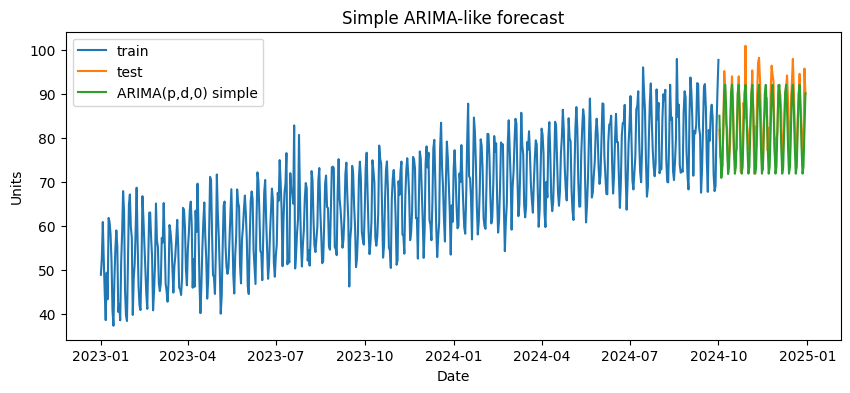

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Simple ARIMA(p,d,0) with optional Fourier seasonality (no extra packages) ====

def make_fourier(t, m=7, K=2):
    """Fourier seasonality features. t is integer time index starting at 1."""
    feats = []
    for k in range(1, K+1):
        feats.append(np.sin(2*np.pi*k*t/m))
        feats.append(np.cos(2*np.pi*k*t/m))
    return np.vstack(feats).T  # shape (n, 2K)

def difference(y, d):
    z = np.asarray(y, dtype=float).copy()
    history = [z.copy()]
    for _ in range(d):
        z = np.diff(z, n=1)
        history.append(z.copy())
    return z, history  # history[0] is original

def undifference(last_levels, diffs, d):
    """Reconstruct level forecasts from diffs given last observed levels."""
    out = []
    prev = last_levels.copy()
    for x in diffs:
        if d == 0:
            out.append(x)
        elif d == 1:
            prev = prev + x
            out.append(prev)
        else:
            # handle d>1 by iterative cumulative sums
            prev_diffs = [x]
            for _ in range(d-1):
                prev_diffs[-1] = prev_diffs[-1] + 0.0  # no-op for clarity
            prev = prev + x
            out.append(prev)
    return np.array(out)

def fit_arima_simple(y, h, p=7, d=1, seasonal_m=7, fourier_k=2):
    """
    ARIMA(p,d,0) with optional Fourier seasonality.
    y: 1D array-like of levels
    h: forecast horizon
    """
    y = np.asarray(y, dtype=float)
    n = len(y)

    # difference
    yd, _ = difference(y, d)

    # build design matrix for AR lags on differenced series
    max_lag = p
    X = []
    target = []
    for t in range(max_lag, len(yd)):
        row = []
        # AR lags
        for lag in range(1, p+1):
            row.append(yd[t-lag])
        # Fourier terms on original time index (start at 1)
        if seasonal_m is not None and fourier_k > 0:
            t_idx = t + d + 1  # align to original time
            row.extend(make_fourier(np.array([t_idx]), m=seasonal_m, K=fourier_k).ravel())
        X.append(row)
        target.append(yd[t])
    X = np.asarray(X)
    target = np.asarray(target)

    # OLS fit
    beta, *_ = np.linalg.lstsq(X, target, rcond=None)

    # one step ahead iterative forecasts on differenced scale
    yd_hist = yd.tolist()
    diffforecasts = []
    for step in range(h):
        row = []
        # lags come from the growing history
        for lag in range(1, p+1):
            row.append(yd_hist[-lag])
        # Fourier at future time index
        if seasonal_m is not None and fourier_k > 0:
            t_future = n + step + 1  # 1-based time for next obs
            row.extend(make_fourier(np.array([t_future]), m=seasonal_m, K=fourier_k).ravel())
        yhat_diff = float(np.dot(row, beta))
        diffforecasts.append(yhat_diff)
        yd_hist.append(yhat_diff)

    # back to levels
    last_level = y[-1]
    level_fc = undifference(np.array(last_level, dtype=float), np.array(diffforecasts), d=1 if d>=1 else 0)
    return level_fc, beta

# ==== Use it on your train/test data ====

# h is the number of test points
h = len(test)
fc, coef = fit_arima_simple(train["y"].values, h=h, p=7, d=1, seasonal_m=7, fourier_k=2)

# Metrics
def mape(a, f):
    a = np.asarray(a, float); f = np.asarray(f, float)
    return np.mean(np.abs((a - f) / np.maximum(1e-8, np.abs(a)))) * 100

def rmse(a, f):
    a = np.asarray(a, float); f = np.asarray(f, float)
    return np.sqrt(np.mean((a - f)**2))

print("RMSE:", rmse(test["y"].values, fc))
print("MAPE:", mape(test["y"].values, fc))

# Plot
plt.figure(figsize=(10,4))
plt.plot(train["ds"], train["y"], label="train")
plt.plot(test["ds"], test["y"], label="test")
plt.plot(test["ds"], fc, label="ARIMA(p,d,0) simple")
plt.legend(); plt.title("Simple ARIMA-like forecast")
plt.xlabel("Date"); plt.ylabel("Units")
plt.show()


## Predictive Analytics in Action
We switch to a supervised ML framing. We engineer calendar features and fit a tree ensemble.

ARX RMSE: 5.384  MAPE: 5.18%


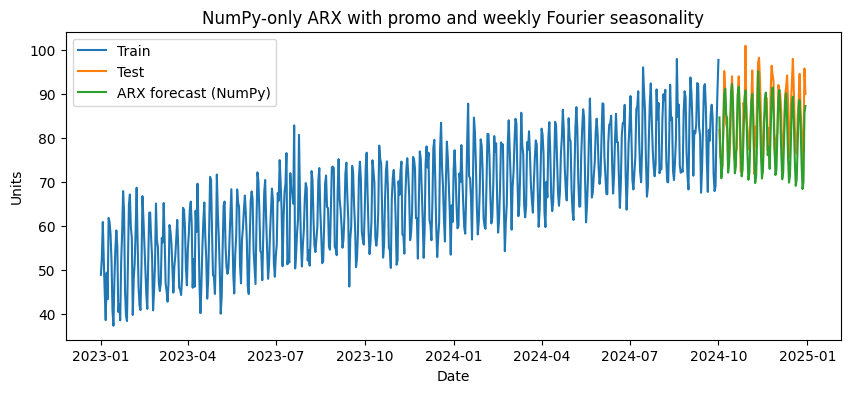

In [ ]:
# ==== ARX (AR with eXogenous) using only NumPy ====
# Works as a drop-in for your "ARIMA + Exog" section.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Settings
p = 7                  # number of AR lags on y
exog_lags = 0          # use contemporaneous promo only; set to >0 to add lagged promo
seasonal_m = 7         # weekly seasonality period; set to None to disable
fourier_k = 2          # number of Fourier pairs for seasonality (sin/cos)

def make_fourier(t_idx, m=7, K=2):
    """Fourier seasonality features for integer time index (1-based)."""
    if m is None or K == 0:
        return np.zeros((len(t_idx), 0))
    out = []
    for k in range(1, K+1):
        out.append(np.sin(2*np.pi*k*t_idx/m))
        out.append(np.cos(2*np.pi*k*t_idx/m))
    return np.vstack(out).T  # shape (n, 2K)

def fit_arx_numpy(y, exog, p=7, exog_lags=0, seasonal_m=None, fourier_k=0):
    """
    Fit y_t = sum_i a_i * y_{t-i} + sum_l B_l * exog_{t-l} + Fourier(t) + c  via OLS.

    y: 1D array of target
    exog: 2D array of exogenous vars (n x k)
    Returns (beta, design_info) where design_info carries sizes for forecasting.
    """
    y = np.asarray(y, float)
    exog = np.asarray(exog, float)
    n, k = exog.shape
    maxlag = max(p, exog_lags)

    rows = []
    target = []
    for t in range(maxlag, n):
        feats = []

        # AR lags
        for lag in range(1, p+1):
            feats.append(y[t-lag])

        # exog with lags
        for L in range(0, exog_lags+1):
            feats.extend(exog[t-L, :])

        # Fourier seasonality on 1-based index
        if seasonal_m is not None and fourier_k > 0:
            feats.extend(make_fourier(np.array([t+1]), m=seasonal_m, K=fourier_k).ravel())

        # intercept
        feats.append(1.0)

        rows.append(feats)
        target.append(y[t])

    X = np.asarray(rows)
    target = np.asarray(target)

    beta, *_ = np.linalg.lstsq(X, target, rcond=None)

    design_info = {
        "p": p,
        "k": k,
        "exog_lags": exog_lags,
        "seasonal_m": seasonal_m,
        "fourier_k": fourier_k,
        "maxlag": maxlag,
        "last_y": y.copy(),      # keep full history for forecasting
        "last_exog": exog.copy() # keep exog history
    }
    return beta, design_info

def forecast_arx_numpy(beta, design_info, exog_future):
    """
    Iterative h-step forecast using learned beta and future exog.
    exog_future: array of shape (h, k)
    """
    p = design_info["p"]
    k = design_info["k"]
    exog_lags = design_info["exog_lags"]
    seasonal_m = design_info["seasonal_m"]
    fourier_k = design_info["fourier_k"]

    y_hist = design_info["last_y"].tolist()
    ex_hist = design_info["last_exog"].tolist()

    h = len(exog_future)
    ex_future = np.asarray(exog_future, float)
    y_fc = []

    # global time index continues from history length
    t0 = len(y_hist)

    for s in range(h):
        feats = []

        # AR lags pulled from growing y_hist
        for lag in range(1, p+1):
            feats.append(y_hist[-lag])

        # exog with lags: take from ex_hist plus new future rows
        # Append the current future exog into a working list so lags line up
        ex_hist.append(ex_future[s].tolist())
        for L in range(0, exog_lags+1):
            feats.extend(ex_hist[-1 - L])

        # Fourier
        if seasonal_m is not None and fourier_k > 0:
            t_idx = t0 + s + 1  # 1-based
            feats.extend(make_fourier(np.array([t_idx]), m=seasonal_m, K=fourier_k).ravel())

        # intercept
        feats.append(1.0)

        y_hat = float(np.dot(feats, beta))
        y_fc.append(y_hat)
        y_hist.append(y_hat)

    return np.array(y_fc)

# Prepare arrays
y_train = train["y"].values
X_train = train[["promo"]].values  # shape (n, 1)
X_future = test[["promo"]].values  # known future promo flags

# Fit and forecast
beta, info = fit_arx_numpy(
    y_train, X_train,
    p=p, exog_lags=exog_lags,
    seasonal_m=seasonal_m, fourier_k=fourier_k
)

sarimax_x_fc = forecast_arx_numpy(beta, info, X_future)  # same name as your earlier code expects

# Metrics and plot
def mape(a, f):
    a = np.asarray(a, float); f = np.asarray(f, float)
    return np.mean(np.abs((a - f) / np.maximum(1e-8, np.abs(a)))) * 100

def rmse(a, f):
    a = np.asarray(a, float); f = np.asarray(f, float)
    return np.sqrt(np.mean((a - f)**2))

print(f"ARX RMSE: {rmse(test['y'].values, sarimax_x_fc):.3f}  MAPE: {mape(test['y'].values, sarimax_x_fc):.2f}%")

plt.figure(figsize=(10,4))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test["ds"], test["y"], label="Test")
plt.plot(test["ds"], sarimax_x_fc, label="ARX forecast (NumPy)")
plt.legend()
plt.title("NumPy-only ARX with promo and weekly Fourier seasonality")
plt.xlabel("Date"); plt.ylabel("Units")
plt.show()


## Financial Analytics and Fraud Detection
We simulate transaction features and train a classifier. This is a toy example to show pipeline structure.

In [ ]:
import numpy as np

# make data similar to sklearn.make_classification
rng = np.random.default_rng(42)
n, p = 15000, 12
X = rng.normal(size=(n, p))
w_true = rng.normal(size=p); w_true[:6] *= 3.0
logits = X @ w_true + rng.normal(0, 1.2, n)
probs = 1.0 / (1.0 + np.exp(-logits))
y = (probs > np.quantile(probs, 0.96)).astype(int)  # ~4 percent positives

# train test split
idx = np.arange(n)
rng.shuffle(idx)
cut = int(n*0.75)
tr, te = idx[:cut], idx[cut:]
X_tr, X_te, y_tr, y_te = X[tr], X[te], y[tr], y[te]

# logistic regression with L2 via gradient descent
def fit_logreg(X, y, lr=0.05, iters=2000, lam=1.0):
    w = np.zeros(X.shape[1])
    for _ in range(iters):
        z = X @ w
        p = 1.0 / (1.0 + np.exp(-z))
        grad = X.T @ (p - y) / len(y) + lam * w
        w -= lr * grad
    return w

w = fit_logreg(X_tr, y_tr)

# predictions
p = 1.0 / (1.0 + np.exp(-(X_te @ w)))
y_hat = (p > 0.5).astype(int)

# metrics
def roc_auc(y_true, score):
    # fast AUC via ranking
    order = np.argsort(score)
    y_sorted = y_true[order]
    n1 = y_sorted.sum()
    n0 = len(y_sorted) - n1
    if n1 == 0 or n0 == 0:
        return np.nan
    rank_sum = np.cumsum(np.ones_like(y_sorted))[y_sorted.astype(bool)].sum()
    # Use standard Mann–Whitney U relation
    return (rank_sum - n1*(n1+1)/2) / (n0*n1)

def cls_report(y_true, y_pred):
    tp = int(((y_true==1) & (y_pred==1)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    prec = tp / max(1, tp+fp)
    rec = tp / max(1, tp+fn)
    f1 = 2*prec*rec / max(1e-8, prec+rec)
    print(f"precision {prec:.3f}  recall {rec:.3f}  f1 {f1:.3f}  tp {tp} fp {fp} tn {tn} fn {fn}")

cls_report(y_te, y_hat)
print("ROC AUC:", roc_auc(y_te, p))


precision 0.081  recall 1.000  f1 0.151  tp 159 fp 1793 tn 1798 fn 0
ROC AUC: 0.9918979839535946


## Review Questions

1. **What type of problem is simulated in this notebook?**

   A. Text classification  
   B. Demand forecasting  
   C. Multi-armed bandit decision-making  
   D. Linear programming optimization  

2. **What does each “arm” represent in the simulation?**

   A. A customer  
   B. A warehouse  
   C. A possible action with its own reward distribution  
   D. A feature used in a model  

3. **How is the reward for an arm generated in the notebook?**

   A. Pulled from a real dataset  
   B. Deterministically calculated  
   C. Randomly sampled from that arm’s distribution  
   D. Predicted using a regression model  

4. **Which quantity is plotted to show how the strategy performs over time?**

   A. Model accuracy  
   B. Loss function  
   C. Cumulative reward (or cumulative regret)  
   D. Feature importance  

5. **Why are multiple strategies (or policies) run and compared in the notebook?**

   A. To remove randomness from the simulation  
   B. To see how different strategies perform over time  
   C. To tune hyperparameters  
   D. To clean the data  

